# Demonstração: Método Green-Kubo no LAMMPS

In [1]:
import lammps
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy import integrate
from scipy.constants import Boltzmann

plt.style.use("dark_background")

In [2]:
lmp = lammps.IPyLammps(
    cmdargs=[
        "-screen",
        "none",
        "-log",
        str("lammps.log"),
    ]
)

LAMMPS output is captured by PyLammps wrapper


In [3]:
RNG = np.random.default_rng(1234)


def generate_seed():
    return RNG.integers(1e4, 1e5)

## Unidades, estado e parâmetros

In [4]:
lmp.units("si")
lmp.dimension(3)

lmp.atom_style("atomic")
lmp.neighbor(2e-10, "bin")

lmp.pair_style("lj/cut", 12e-10)
lmp.pair_modify("mix", "arithmetic", "tail", "yes")

## Átomos e caixa de simulação

In [5]:
L = 400e-10
substances = ["N2"]
num_atoms = [500]

In [6]:
lmp.boundary("p p p")

lmp.region("simulation_box block", 0, L, 0, L, 0, L)
# lmp.lattice("fcc", 5.376e-10, "orient x 1 0 0 orient y 0 1 0 orient z 0 0 1")

lmp.create_box(len(substances), "simulation_box")

for i, substance in enumerate(substances):
    lmp.labelmap("atom", i + 1, substance)

for i, num in enumerate(num_atoms):
    lmp.create_atoms(i + 1, "random", num, generate_seed(), "simulation_box")

In [7]:
lmp.mass("N2", 2.3258671e-26)
# lmp.mass("O2", 2.6566962e-26)
lmp.pair_coeff("N2", "N2", 71.4 * Boltzmann, 3.798e-10)
# lmp.pair_coeff("O2", "O2", 106.7 * Boltzmann, 3.467e-10)

In [8]:
lmp.variable("step equal step")

# Variáveis termodinâmicas
lmp.variable("V equal vol")
lmp.variable("P equal press")
lmp.variable("D equal density")

# Tensor de pressão
lmp.variable("Pxy equal pxy")
lmp.variable("Pxz equal pxz")
lmp.variable("Pyz equal pyz")

# Fluxo de calor
lmp.compute("myKE all ke/atom")
lmp.compute("myPE all pe/atom")
lmp.compute("myStress all stress/atom NULL virial")
lmp.compute("flux all heat/flux myKE myPE myStress")

lmp.variable("Jx equal c_flux[1]/vol")
lmp.variable("Jy equal c_flux[2]/vol")
lmp.variable("Jz equal c_flux[3]/vol")

## Equilibração e definição do ensemble

In [9]:
dt = 1.0e-15
T = 200
savestep = 5

In [ ]:
lmp.timestep(dt)
lmp.thermo(savestep)

lmp.thermo_style(
    "custom",
    "step time temp press v_Pxy v_Pxz v_Pyz v_Jx v_Jy v_Jz",
)
lmp.minimize(1.0e-4, 1.0e-6, 1000, 10000)

In [11]:
T_init = 1.2 * T

lmp.velocity("all create", T_init, generate_seed(), "mom yes rot yes dist gaussian")
lmp.fix("NVT all nvt temp", T_init, T_init, 100 * dt, "drag", 0.2)
lmp.run(8000)

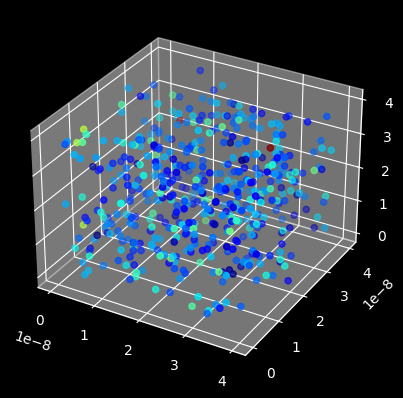

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

x, y, z = lmp.lmp.numpy.extract_atom("x").T
v = np.linalg.norm(lmp.lmp.numpy.extract_atom("v"), axis=1)

ax.scatter(x, y, z, c=v, cmap="jet")

plt.show()

## Execução da simulação

In [13]:
runtime = 1000e-12

lmp.reset_timestep(0)

In [14]:
# Variáveis para cálculo da correlação
N_every = 5
N_repeat = 20000
N_freq = N_every * N_repeat

lmp.fix(
    "SS",
    "all",
    "ave/correlate",
    N_every,
    N_repeat,
    N_freq,
    "v_Pxy v_Pxz v_Pyz",
    "type auto",
    "file S0St.dat",
    "ave running",
)

lmp.fix(
    "JJ",
    "all",
    "ave/correlate",
    N_every,
    N_repeat,
    N_freq,
    "v_Jx v_Jy v_Jz",
    "type auto",
    "file J0Jt.dat",
    "ave running",
)

lmp.variable("vxy equal trap(f_SS[3])")
lmp.variable("vxz equal trap(f_SS[4])")
lmp.variable("vyz equal trap(f_SS[5])")

lmp.variable("kx equal trap(f_JJ[3])")
lmp.variable("ky equal trap(f_JJ[4])")
lmp.variable("kz equal trap(f_JJ[5])")

In [15]:
lmp.thermo_style(
    "custom",
    "step time temp press v_Pxy v_Pxz v_Pyz v_Jx v_Jy v_Jz",
)

In [16]:
runtime = 1000e-12

In [17]:
lmp.velocity("all create", T, generate_seed(), "mom yes rot yes dist gaussian")
lmp.fix("NVT all nvt temp", T, T, 100 * dt, "drag", 0.2)

lmp.run(int(runtime / dt))

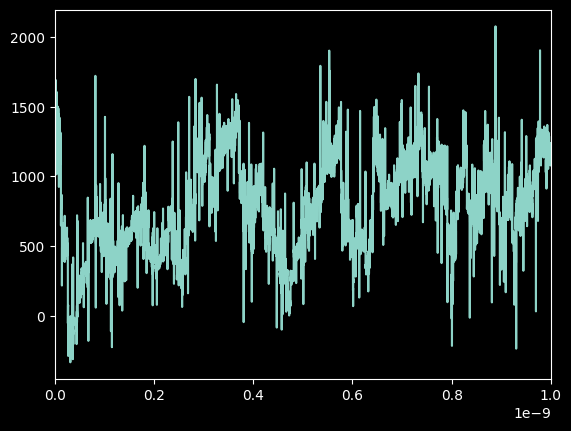

In [18]:
time = np.array(lmp.last_run.thermo.Time)
Pxy = np.array(lmp.last_run.thermo.v_Pxy)
# Pxz = np.array(lmp.last_run.thermo.v_Pxz) / 101325
# Pyz = np.array(lmp.last_run.thermo.v_Pyz) / 101325


plt.plot(time, Pxy)
# plt.plot(time, Pxz)
# plt.plot(time, Pyz)

plt.margins(x=0)
plt.show()

In [19]:
def autocorrelation(data):
    steps = data.shape[0]
    lag = steps // 2

    # Nearest size with power of 2 (for efficiency) to zero-pad the input data
    size = 2 ** np.ceil(np.log2(2 * steps - 1)).astype("int")

    # Compute the FFT
    FFT = np.fft.fft(data, size)

    # Get the power spectrum
    PWR = FFT.conjugate() * FFT

    # Calculate the auto-correlation from inverse FFT of the power spectrum
    COR = np.fft.ifft(PWR)[:steps].real

    autocorrelation = COR / np.arange(steps, 0, -1)

    return autocorrelation[:lag]

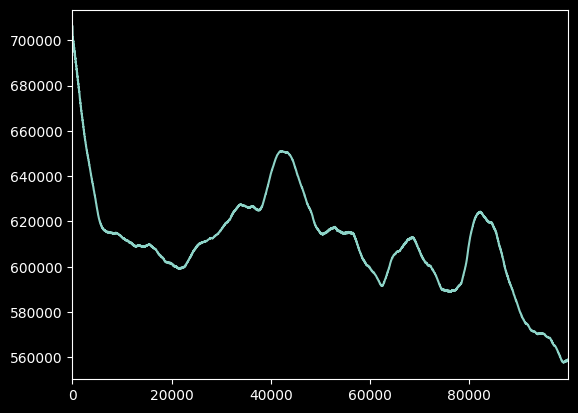

In [20]:
Pxy_corr = autocorrelation(Pxy)

plt.plot(Pxy_corr)

plt.margins(x=0)
plt.show()

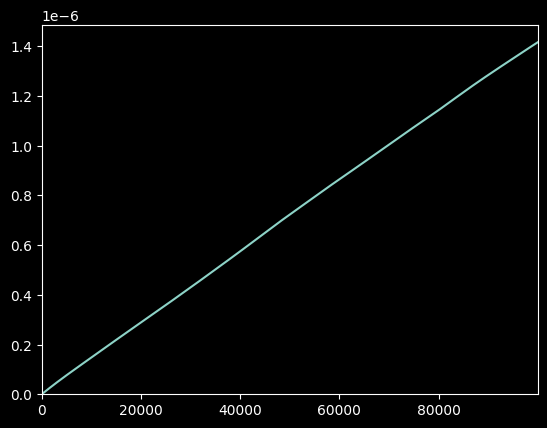

In [21]:
integral = integrate.cumulative_trapezoid(y=Pxy_corr, dx=dt)
viscosity = integral * L**3 / (Boltzmann * T)

plt.plot(viscosity)

plt.margins(x=0)
plt.ylim(bottom=0)
plt.show()

In [22]:
print(viscosity[-1])

1.4152928674330402e-06


In [23]:
lmp.variables["vxy"].value * L**3 / (Boltzmann * T)

288749091.4358552

## Pós processamento